<a href="https://colab.research.google.com/github/GailB-ca/digital-display-reader/blob/main/Digit_Identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import pickle
import numpy as np
from matplotlib import pyplot as plt

from google.colab import drive


In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
with tf.compat.v1.Session(config=config):
    pass  # init sessin with allow_growth


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filename = "/content/drive/MyDrive/Colab Notebooks/training_df.pk"
training_numbers_df = pickle.load(open(filename, 'rb'))

In [ ]:
training_numbers_df.head()

,box_order,class,image_id,image_path,xmax,xmin,ymax,ymin,width,height,portrait,img_num_arr,img_num_bw_arr,img_num_width,img_num_height,img_num_arr_resize,class_arr
0,0.0,1,0.0,/Users/gbishop/lighthouse/data_bootcamp/digita...,2166,1740,2070,1799,426,271,0,"[[[221, 208, 210], [221, 208, 210], [221, 208,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",271,426,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",[1]
1,1.0,5,0.0,/Users/gbishop/lighthouse/data_bootcamp/digita...,2186,1710,1775,1514,476,261,0,"[[[38, 51, 49], [38, 51, 49], [37, 50, 48], [3...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",261,476,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",[5]
2,2.0,0,0.0,/Users/gbishop/lighthouse/data_bootcamp/digita...,2131,1690,1535,1194,441,341,0,"[[[36, 50, 48], [35, 49, 47], [36, 50, 48], [3...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",341,441,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",[0]
3,3.0,9,0.0,/Users/gbishop/lighthouse/data_bootcamp/digita...,2661,2165,1785,1469,496,316,0,"[[[46, 63, 60], [44, 61, 58], [48, 65, 62], [4...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",316,496,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",[9]
4,4.0,4,0.0,/Users/gbishop/lighthouse/data_bootcamp/digita...,2601,2135,1455,1154,466,301,0,"[[[55, 72, 68], [55, 72, 68], [55, 72, 68], [5...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",301,466,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",[4]


In [ ]:
# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=25,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=False,
    fill_mode="nearest",
    validation_split=0.2)

testAug = ImageDataGenerator(rescale=1/255.0)

In [ ]:
# Shuffle the rows
from sklearn.utils import shuffle
training_numbers_df = shuffle(training_numbers_df)

In [ ]:
X = np.array(training_numbers_df['img_num_arr_resize'].values.tolist())
Y = np.array(training_numbers_df['class_arr'].values.tolist())

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

In [ ]:
X_train = tf.keras.applications.resnet50.preprocess_input(X_train)
Y_train = tf.keras.utils.to_categorical(Y_train)

X_test = tf.keras.applications.resnet50.preprocess_input(X_test)
Y_test = tf.keras.utils.to_categorical(Y_test)

In [ ]:
#learning_rate = 1e-6 # poor performance
learning_rate = 1e-4
#learning_rate = 1e-2 # Poor performance
#num_epochs = 10 # good performance
#num_epochs = 64 # Poor performance
num_epochs = 16

batch_size = 16 # good performance for basemodel
#batch_size=32 # Words for model2

img_shape = (600, 400, 3)

In [ ]:
trainGen = trainAug.flow(X_train, Y_train, batch_size=batch_size, subset="training", shuffle=True)
valGen = trainAug.flow(X_train, Y_train, batch_size=batch_size, subset="validation", shuffle=True)
testGen = testAug.flow(X_test, Y_test, batch_size=batch_size)

In [ ]:
print("Size of Training Data: ", trainGen.n)

Size of Training Data:  695


In [ ]:
# VERSION 1
baseModel = ResNet50(weights=None, include_top=True,
                    input_tensor=Input(shape=img_shape),
                    classes=10)


In [ ]:
# VERSION 2
#from keras.layers import Dense, GlobalAveragePooling2D
#from keras.models import Model

#base_model = ResNet50(weights='imagenet', include_top=False,
#                             input_tensor=Input(shape=img_shape))

# Taking the output of the last convolution block in ResNet50
#x = base_model.output
 
# Adding a Global Average Pooling layer
#x = GlobalAveragePooling2D()(x)
 
# Adding a fully connected layer having 1024 neurons
#x = Dense(1024, activation='relu')(x)
 
# Adding a fully connected layer having 10 neurons which will
# give the probability of image having digits 0 to 10
#predictions = Dense(10, activation='softmax')(x)
 
# Model to be trained
#baseModel = Model(inputs=base_model.input, outputs=predictions)
 
# Training only top layers i.e. the layers which we have added in the end
#for layer in base_model.layers:
#    layer.trainable = False


In [ ]:
# VERSION 3
classifier_vgg16 = VGG16(
    input_shape = img_shape,
    include_top = False,
    weights = 'imagenet')
classifier_resnet = ResNet50(
    input_shape = img_shape,
    include_top = False,
    weights = 'imagenet')

# Don't train existing weights for vgg16 and resnet50
for layer in classifier_vgg16.layers:
    layer.trainable = False
for layer in classifier_resnet.layers:
    layer.trainable = False

In [ ]:
#VGG16
classifier1 = classifier_vgg16.output#head mode
classifier1 = layers.Flatten()(classifier1)#adding layer of flatten
classifier1 = layers.Dense(units=256, activation='relu')(classifier1)
classifier1 = layers.Dropout(0.6)(classifier1)
classifier1 = layers.Dense(units=10, activation='softmax')(classifier1)

model = Model(inputs = classifier_vgg16.input , outputs = classifier1)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#resnet50
classifier2 = classifier_resnet.output#head mode
classifier2 = layers.Flatten()(classifier2)#adding layer of flatten
classifier2 = layers.Dropout(0.6)(classifier2)
classifier2 = layers.Dense(units=10, activation='softmax')(classifier2)

model2 = Model(inputs = classifier_resnet.input , outputs = classifier2)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
#fit the model
#resnet50
history2 = model2.fit(trainGen,
                   steps_per_epoch=trainGen.n // batch_size, 
                   epochs=num_epochs,
                   validation_data=valGen,
                   validation_steps=valGen.n // batch_size,
                   verbose=1)


Epoch 1/16
21/21 [==============================] - 47s 2s/step - loss: 151.4616 - accuracy: 0.1722 - val_loss: 91.4923 - val_accuracy: 0.1500
Epoch 2/16
21/21 [==============================] - 42s 2s/step - loss: 61.3149 - accuracy: 0.2479 - val_loss: 18.7412 - val_accuracy: 0.4563
Epoch 3/16
21/21 [==============================] - 41s 2s/step - loss: 13.0119 - accuracy: 0.5753 - val_loss: 8.6713 - val_accuracy: 0.6313
Epoch 4/16
21/21 [==============================] - 41s 2s/step - loss: 7.6950 - accuracy: 0.6188 - val_loss: 5.1786 - val_accuracy: 0.7375
Epoch 5/16
21/21 [==============================] - 41s 2s/step - loss: 8.7956 - accuracy: 0.6634 - val_loss: 8.3488 - val_accuracy: 0.6375
Epoch 6/16
21/21 [==============================] - 41s 2s/step - loss: 7.6424 - accuracy: 0.6948 - val_loss: 12.9879 - val_accuracy: 0.6250
Epoch 7/16
21/21 [==============================] - 41s 2s/step - loss: 12.4956 - accuracy: 0.6329 - val_loss: 12.3185 - val_accuracy: 0.6187
Epoch 8/16


In [ ]:
history3 = model.fit(trainGen,
                   steps_per_epoch=trainGen.n // batch_size, 
                   epochs=num_epochs,
                   validation_data=valGen,
                   validation_steps=valGen.n // batch_size,
                   verbose=1)

Epoch 1/16


ResourceExhaustedError: ignored

In [ ]:
opt = Adam(lr=learning_rate, 
           decay=learning_rate / num_epochs)
baseModel.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
print("Steps per epoch", trainGen.n // batch_size)
print("Number of epochs", num_epochs)
print("Validation data", valGen.n)

Steps per epoch 21
Number of epochs 64
Validation data 173


In [ ]:
train_history = baseModel.fit(trainGen,
                   steps_per_epoch=trainGen.n // batch_size, 
                   epochs=num_epochs,
                   validation_data=valGen,
                   validation_steps=valGen.n // batch_size,
                   verbose=1)

Epoch 1/16
43/43 [==============================] - 52s 1s/step - loss: 2.4510 - accuracy: 0.2208 - val_loss: 2.5055 - val_accuracy: 0.1625
Epoch 2/16
43/43 [==============================] - 42s 982ms/step - loss: 1.7763 - accuracy: 0.4064 - val_loss: 2.8124 - val_accuracy: 0.1688
Epoch 3/16
43/43 [==============================] - 43s 989ms/step - loss: 1.3850 - accuracy: 0.5148 - val_loss: 5.0568 - val_accuracy: 0.1875
Epoch 4/16
43/43 [==============================] - 43s 996ms/step - loss: 1.1422 - accuracy: 0.6097 - val_loss: 3.7314 - val_accuracy: 0.1688
Epoch 5/16
43/43 [==============================] - 43s 990ms/step - loss: 0.9569 - accuracy: 0.7095 - val_loss: 5.6520 - val_accuracy: 0.1688
Epoch 6/16
43/43 [==============================] - 43s 991ms/step - loss: 0.8251 - accuracy: 0.7266 - val_loss: 5.6694 - val_accuracy: 0.1813
Epoch 7/16
43/43 [==============================] - 43s 998ms/step - loss: 0.6837 - accuracy: 0.7791 - val_loss: 5.2391 - val_accuracy: 0.1750
Ep

In [ ]:
# VERSION 2 - fit it again
for layer in base_model.layers[0:143]:
  layer.trainable = False
 
for layer in base_model.layers[143:]:
  layer.trainable = True

In [ ]:
train_history = baseModel.fit(trainGen,
                   steps_per_epoch=trainGen.n // batch_size, 
                   epochs=num_epochs,
                   validation_data=valGen,
                   validation_steps=valGen.n // batch_size,
                   verbose=1)

Epoch 1/10
43/43 [==============================] - 44s 1s/step - loss: 2.2874 - accuracy: 0.1977 - val_loss: 2.2439 - val_accuracy: 0.1875
Epoch 2/10
43/43 [==============================] - 43s 1s/step - loss: 2.2565 - accuracy: 0.2150 - val_loss: 2.3044 - val_accuracy: 0.2000
Epoch 3/10
43/43 [==============================] - 43s 1s/step - loss: 2.2691 - accuracy: 0.2253 - val_loss: 2.4765 - val_accuracy: 0.1375
Epoch 4/10
43/43 [==============================] - 43s 999ms/step - loss: 2.2717 - accuracy: 0.2003 - val_loss: 2.2193 - val_accuracy: 0.2062
Epoch 5/10
43/43 [==============================] - 43s 1s/step - loss: 2.2379 - accuracy: 0.2430 - val_loss: 2.4993 - val_accuracy: 0.2062
Epoch 6/10
43/43 [==============================] - 43s 1s/step - loss: 2.2736 - accuracy: 0.2224 - val_loss: 2.2062 - val_accuracy: 0.2313
Epoch 7/10
43/43 [==============================] - 43s 1s/step - loss: 2.2722 - accuracy: 0.2003 - val_loss: 2.2371 - val_accuracy: 0.2313
Epoch 8/10
43/43 

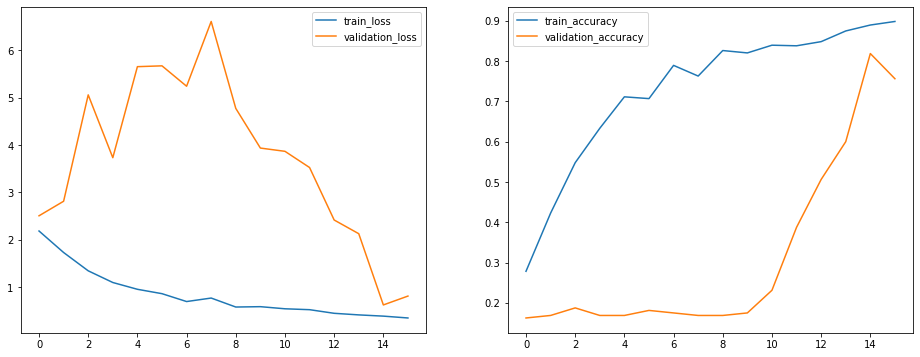

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[16,6])
ax1.plot(train_history.history['loss'], label='train_loss')
ax1.plot(train_history.history['val_loss'], label='validation_loss')
ax1.legend()
ax2.plot(train_history.history['accuracy'], label='train_accuracy')
ax2.plot(train_history.history['val_accuracy'], label='validation_accuracy')
ax2.legend();

In [ ]:
testGen.reset()
predIdxs = baseModel.predict(
    testGen,
	  steps=(testGen.n // batch_size) + 1)

In [ ]:
# VERSION 3
testGen.reset()
predIdxs = model2.predict(
    testGen,
	  steps=(testGen.n // batch_size) + 1)


In [ ]:
print(predIdxs)
predIdxs = np.argmax(predIdxs, axis=1)

[[9.6073812e-01 2.9458373e-03 3.2921348e-04 ... 2.1122906e-03
  2.9014967e-02 2.7259006e-03]
 [3.6257264e-04 3.8831278e-03 6.7016191e-04 ... 2.1605723e-02
  2.4281647e-03 2.7197007e-02]
 [5.1911394e-07 7.8630521e-08 3.1927244e-03 ... 3.5706194e-04
  7.6226399e-07 6.6609993e-03]
 ...
 [3.6129859e-05 9.5474631e-01 9.2062727e-04 ... 2.0761836e-02
  1.4215594e-03 4.4857822e-03]
 [1.6439039e-03 9.1543669e-05 2.0390267e-03 ... 2.0555117e-04
  2.8053427e-03 1.0183118e-03]
 [6.0545797e-03 7.7401037e-06 5.5201384e-05 ... 5.8297999e-05
  9.6265131e-01 2.9504417e-02]]


In [ ]:
from sklearn.metrics import classification_report
print(predIdxs)
Y_expected = np.argmax(Y_test, axis=1)
print(Y_expected)
print(classification_report(Y_expected, predIdxs, zero_division=0))	

[0 4 3 0 6 1 7 6 3 1 6 1 8 6 6 5 9 5 5 5 1 4 7 2 5 4 0 6 4 2 2 1 0 7 7 4 6
 1 3 6 7 3 8 8 8 1 9 3 6 8 1 6 8 1 1 2 6 1 8 7 5 7 5 9 5 7 6 0 6 1 7 7 1 1
 0 7 0 6 8 0 3 7 4 7 8 1 0 1 6 1 3 6 1 6 8 8 3 1 6 2 7 7 5 4 1 5 0 1 6 7 0
 1 1 8 4 4 6 8 6 3 7 3 7 7 9 6 1 2 3 5 5 6 3 7 7 9 8 7 1 5 7 8 7 1 8 4 1 5
 3 1 4 3 1 9 8 5 1 2 3 6 1 5 4 0 4 9 9 1 1 7 1 5 7 8 7 7 5 3 1 6 6 1 5 5 4
 6 8 1 3 3 2 1 5 5 1 7 9 9 9 0 9 6 1 1 2 5 1 2 5 9 8 1 0 1 1 1 6 8]
[1 8 6 1 6 9 9 8 5 5 7 1 1 0 1 8 1 6 1 7 0 1 1 5 7 9 1 1 4 7 6 3 1 4 1 7 2
 9 6 7 8 6 3 4 7 1 3 6 4 3 7 6 9 8 0 1 5 3 4 5 3 6 1 7 2 5 7 3 8 5 1 4 7 5
 4 6 0 7 4 5 7 0 8 7 1 8 8 3 2 1 6 4 1 2 7 9 6 7 1 0 7 5 1 1 5 1 8 1 0 8 1
 6 1 8 9 5 8 1 4 5 5 6 6 2 5 1 2 6 8 2 2 4 1 3 3 1 4 9 8 0 2 3 6 3 5 6 7 8
 8 2 8 5 7 8 6 0 4 7 7 8 5 1 1 9 2 7 4 1 7 1 7 1 1 1 3 6 6 6 1 7 4 4 6 3 1
 2 0 1 6 6 5 9 3 9 6 5 6 2 7 3 2 4 7 1 2 2 7 1 0 9 4 4 9 2 6 6 1 7]
              precision    recall  f1-score   support

           0       0.07      0.09      0.08        11
     